In [7]:
library(dagitty)
library(lavaan)


## Generate Simple DAGs

In [2]:
g <- dagitty('dag {
             X [pos="0,0"]
             Y [pos="0,2"]
             Z [pos="1,1"]
  X -> Z
  Y -> Z
}')


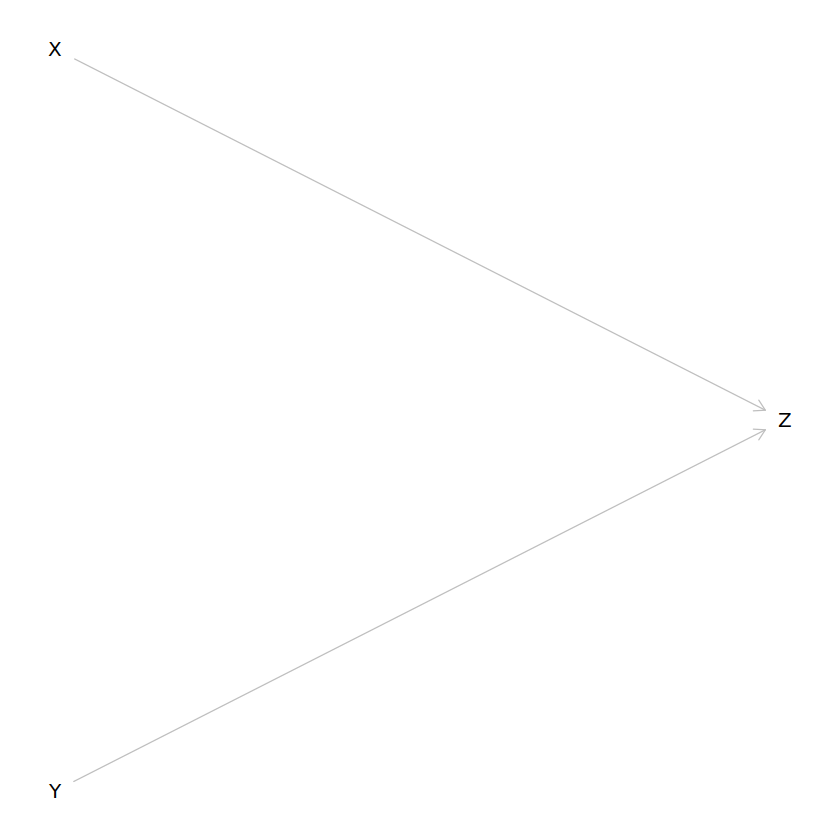

In [3]:
plot(g)


In [4]:
paths(g, "X", "Z")


$paths
[1] "X -> Z"

$open
[1] TRUE

## Creating an Artificial Data Set Matching a Structural Causal Model (SCM)

We'll use the `lavaan` library and its syntax to create our SCM:

In [6]:
lavaan_model <- "Z ~ 3*X + 2*Y"
set.seed(12345)
g_tbl <- simulateData(lavaan_model, sample.nobs = 1000)


Now we'll fit the model using a traditional structured equations model (SEM):

In [6]:
lavaan_fit <- sem(lavaan_model, data = g_tbl)


Unsurprisingly, the fit matches the SCM above

In [7]:
parameterEstimates(lavaan_fit)


lhs,op,rhs,est,se,z,pvalue,ci.lower,ci.upper
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Z,~,X,3.000000000,0.000000,NA,NA,3.000000000,3.000000000
Z,~,Y,2.000000000,0.000000,NA,NA,2.000000000,2.000000000
Z,~~,Z,0.913992878,0.040875,22.36068,0,0.833879342,0.994106414
X,~~,X,0.966490602,0.000000,NA,NA,0.966490602,0.966490602
X,~~,Y,0.006445564,0.000000,NA,NA,0.006445564,0.006445564
Y,~~,Y,1.046250854,0.000000,NA,NA,1.046250854,1.046250854


## Estimating an SCM when not Knowing It

Fitting a linear model to Z and X, using the data generated above:

In [8]:
lm(Z ~ X, data = g_tbl)



Call:
lm(formula = Z ~ X, data = g_tbl)

Coefficients:
(Intercept)            X  
  -0.008156     3.019497  


To get the true causal effect of $X$ on $Z$, `dagitty` can provide us with the variables we need to condition on (using the rules of Pearl's d-separation).

In [9]:
adjustmentSets(g, "X", "Z", type = "all")


 {}
{ Y }

To do this, for a more complex causal model we could adjust e.g. for colliders ($T$):\
`lm(Z ~ X + T, data = g_tbl)`\
that is, add `+ V` after $X$ for all the variables stated in one of the adjustment sets outputted with `adjustmentSets()`.

## Unobserved Variables

We can define unobserved, or "latent", variables in `dagitty`:

In [10]:
g_unobs <- g
latents(g_unobs) <- c("Y")


Note how this changes the adjustment sets:

In [11]:
adjustmentSets(g_unobs, "X", "Z", type = "minimal")


 {}

For this very simple model we are out of luck.
But for complex causal models with several variables and paths, even if some variables are unobserved we might find adjustment sets composed of observed variables.

## Conditional Independence

For the simple collider model $X → Z ← Y$, by the rules of Pearl's d-separation we know that $X$ and $Y$ are conditionally independent, and that conditioning on $Z$ renders them dependent.
That is,
$$P(X = x | Y = y) = P(X = x)$$
*except* whenever we condition on $Z$.
This implication of a causal model can be tested with regressions on empirical data sets:

In [13]:
lm(Y ~ X, data = g_tbl)



Call:
lm(formula = Y ~ X, data = g_tbl)

Coefficients:
(Intercept)            X  
   0.002671     0.006669  


As this data by design does not match exactly the lavaal SCM above, the regression outputs a non-zero value.
It is very close to zero though, a situation that changes when we condition on $Z$, rendering both variables dependent:

In [14]:
lm(Y ~ X + Z, data = g_tbl)



Call:
lm(formula = Y ~ X + Z, data = g_tbl)

Coefficients:
(Intercept)            X            Z  
    0.00601     -1.22921      0.40930  


And we can straightforwardly use dagitty's `impliedConditionalIndependencies()`:

In [15]:
impliedConditionalIndependencies(g)


X _||_ Y